# 1. Data Preprocessing

## Converting provided PDF into individual page Images

In [1]:
from src.dataUtils import pdf_to_images

In [5]:
pdf_to_images(
    pdf_path="data/1.raw/HandwrittenPages/AHPG-GPAH 1&#x3a;1716,A.35 – 1744.pdf",
    output_dir="data/2.images/HandwrittenPages",
)
pdf_to_images(
    pdf_path="data/1.raw/PrintedPages/Padilla - 1 Nobleza virtuosa (1637).pdf",
    output_dir="data/2.images/PrintedPages",
    page_range=(5,8)
)
pdf_to_images(
    pdf_path="data/1.raw/HandwrittenPages/AGG-GAO JDIM3&#x3a;8&#x3a;47 - 1684.pdf",
    output_dir="data/2.images/HandwrittenPages",
    page_list=[3,4,5]
)

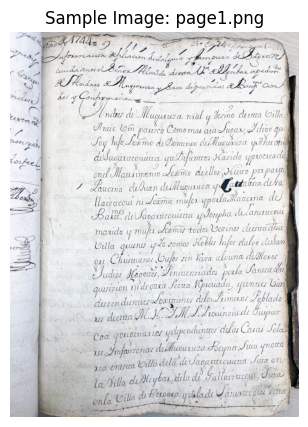

In [2]:
from src.dataUtils import display_sample
display_sample("data/2.images/HandwrittenPages/easy/page1.png")

## Preprocessing Images

In [2]:
from src.dataUtils import process_image_folder

In [5]:
# default pipeline that applies to all pages except if overridden by page_pipelines(for specific pages or page ranges)
default_pipeline = [
    {"op": "grayscale"},
    # {"op": "deskew"},
    # {"op": "binarize"}
]
# page_pipelines = {
#     (2,3): [
#         {"op": "contrast"},  
#     ],

#     8: [
#         {"op": "deskew"},
#         {"op": "binarize", "params": {"method":"adaptive"}}
#     ]
# }

In [6]:
process_image_folder(
    input_dir="data/2.images/PrintedPages/Padilla - 1 Nobleza virtuosa (1637)",
    output_dir="data/3.processed",
    default_pipeline=default_pipeline,
    # page_pipelines=page_pipelines
)

Page 1 processed
Page 2 processed
Page 3 processed
Page 4 processed
Page 5 processed
Page 6 processed
Page 7 processed
Page 8 processed


# 2. Text Detection(Line Level)

Progress: |██████████████████████████████████████████████████| 100.0% Complete✅ EasyOCR detector ready (Spanish)
Raw detected boxes: 26
Filtered boxes: 26
Line crops: 26


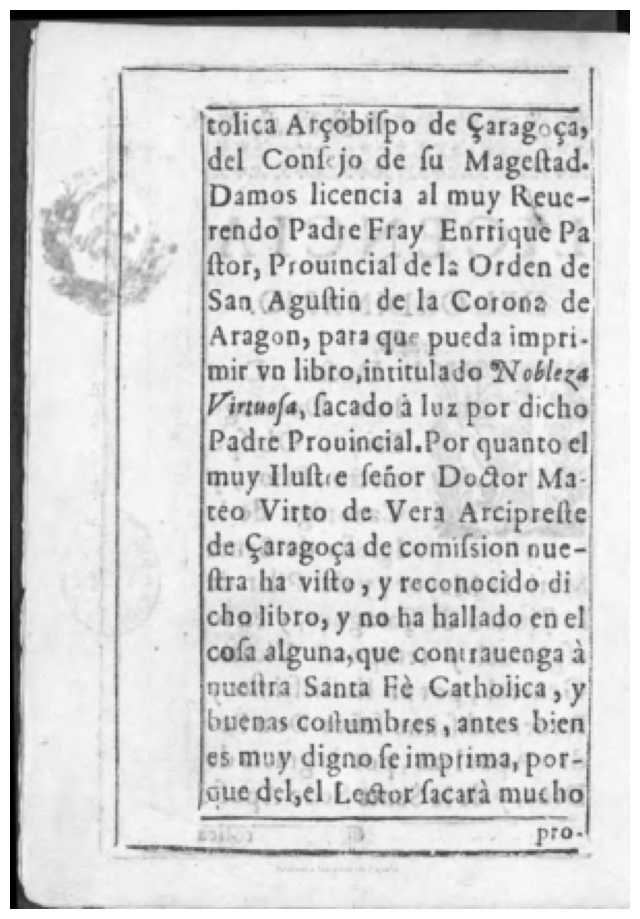

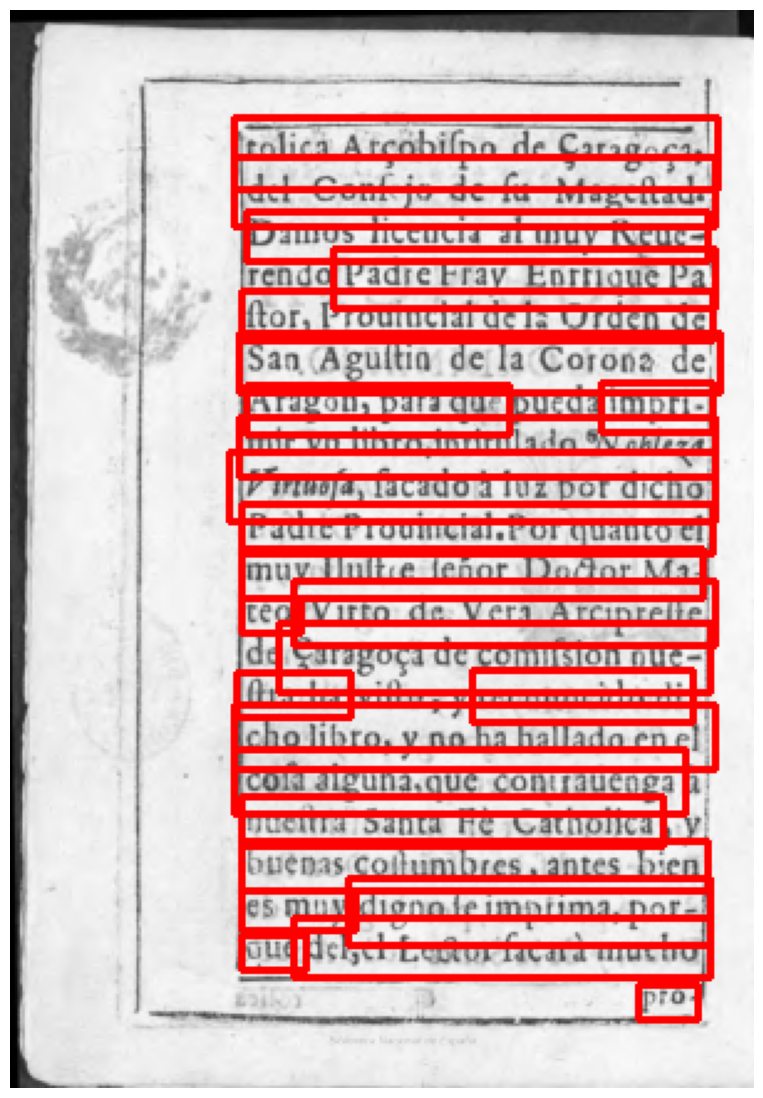

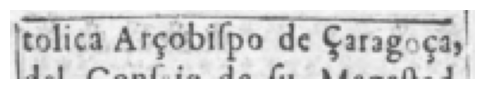

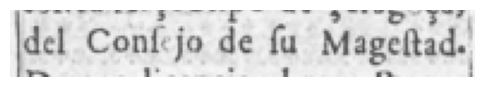

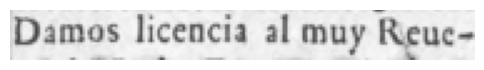

In [26]:
# =========================
# EASY OCR — SPANISH LINE DETECTION (TUNABLE)
# =========================

import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 🔧 HYPERPARAMETERS — TUNE HERE
# =========================

IMAGE_PATH = "data/3.processed/page1.png"

LANGUAGES = ['es']          # Spanish
USE_GPU = True

TEXT_THRESHOLD = 0.5        # lower → detect faint text
LOW_TEXT = 0.3              # lower → more sensitive
LINK_THRESHOLD = 0.2        # lower → merge nearby components

MIN_BOX_HEIGHT = 10         # filter tiny noise boxes
DRAW_THICKNESS = 2

# =========================
# LOAD READER
# =========================

reader = easyocr.Reader(LANGUAGES, gpu=USE_GPU)
print("✅ EasyOCR detector ready (Spanish)")

# =========================
# LOAD IMAGE
# =========================

img = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,12))
plt.imshow(img_rgb)
plt.axis("off")

# =========================
# DETECTION (DBNet under hood)
# =========================

h_boxes, f_boxes = reader.detect(
    IMAGE_PATH,
    text_threshold=TEXT_THRESHOLD,
    low_text=LOW_TEXT,
    link_threshold=LINK_THRESHOLD
)

line_boxes = h_boxes[0]

print("Raw detected boxes:", len(line_boxes))

# =========================
# FILTER SMALL BOXES (optional)
# =========================

filtered_boxes = []

for (xmin, xmax, ymin, ymax) in line_boxes:
    if (ymax - ymin) >= MIN_BOX_HEIGHT:
        filtered_boxes.append((xmin, xmax, ymin, ymax))

print("Filtered boxes:", len(filtered_boxes))

# =========================
# VISUALIZE
# =========================

vis = img_rgb.copy()

for (xmin, xmax, ymin, ymax) in filtered_boxes:

    cv2.rectangle(
        vis,
        (int(xmin), int(ymin)),
        (int(xmax), int(ymax)),
        (255,0,0),
        DRAW_THICKNESS
    )

plt.figure(figsize=(10,14))
plt.imshow(vis)
plt.axis("off")

# =========================
# CROP LINE IMAGES
# =========================

line_crops = []

for (xmin, xmax, ymin, ymax) in filtered_boxes:

    crop = img_rgb[int(ymin):int(ymax), int(xmin):int(xmax)]
    line_crops.append(crop)

print("Line crops:", len(line_crops))

# preview first few
for i in range(min(3, len(line_crops))):
    plt.figure(figsize=(6,2))
    plt.imshow(line_crops[i])
    plt.axis("off")


# 3. Building the C-RNN OCR Model

# 4. Inference

# Using Gemini API

In [2]:
from google import genai
from google.genai import types
import dotenv
import os

# ============================
# Load API Key
# ============================
dotenv.load_dotenv()

API_KEY = os.getenv("GEMINI_API_KEY")

if not API_KEY:
    raise ValueError("GEMINI_API_KEY not found in .env")

client = genai.Client(api_key=API_KEY)


In [3]:
# ============================
# Model — use flash for free tier
# ============================
MODEL_NAME = "gemini-3-flash-preview"

# ============================
# OCR Function — ONE IMAGE ONLY
# ============================

def gemini_ocr(image_path: str):

    with open(image_path, "rb") as f:
        img_bytes = f.read()

    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=[
            types.Part.from_bytes(
                data=img_bytes,
                mime_type="image/png"   # change if jpeg
            ),
            "Extract all readable text from this image. Return only the transcript."
        ],
    )

    return response.text


# ============================
# Run — single image
# ============================

text = gemini_ocr("data/3.processed/page4.png")

print("Transcript:\n")
print(text)

Transcript:

za Arçobiſpo de Çaragoça, y
del Conſejo de ſu Mageſtad.
He viſto eſte libro, exortacion,
o diſcurſo intitulado Nobleza
Virtuoſa, ſacado à luz por el muy
Reuerendo Padre Fray Enri-
que Paſtor, Prouincial de la Or
den de San Aguftin en la Coro-
na de Aragon, Y ſi ſu Autor re-
tirò ſu nombre, la mano que no
ſe encoge cudicioſa, no permi-
te que menos que la eſtampa
eternize la comunicacion de
tanto beneficio, ſeguro que lo
gozen todos, quando lo eſclare-
cido y noble ſin deſuanecer ſus
merecidos titulos, reconoze los
efectos en ſu verdadero origen,
dieſtro enlaze de la Nobleza,
con el natiuo y juſto valor de lo
¶ 3 Vir-
